In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('monthly_quantities.csv')

In [3]:
df.head()

,Date,quantity
0,2020-01,618
1,2020-02,666
2,2020-03,1021
3,2020-04,1267
4,2020-05,987


In [4]:
df.tail()

,Date,quantity
19,2021-08,725
20,2021-09,671
21,2021-10,572
22,2021-11,672
23,2021-12,750


In [5]:
df.shape

(24, 2)

In [6]:
print(f"Date range of quantity from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of quantity from - 2020-01 to 2021-12


In [7]:
print(f"Date range of quantity from {df.loc[:,'Date'][0]} to {df.loc[0:,'Date'][len(df)-1]}")

Date range of quantity from 2020-01 to 2021-12


In [8]:
date = pd.date_range(start = '1/1/2020', end='1/12/2022', freq='M')
date

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', freq='M')

In [9]:
print(date)

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', freq='M')


In [10]:
df['month']=date
df.drop('Date', axis =1, inplace= True)
df = df.set_index('month')
df.head()

,quantity
month,
2020-01-31,618
2020-02-29,666
2020-03-31,1021
2020-04-30,1267
2020-05-31,987


# Step 1. EDA(Exploratory Data Analysis)

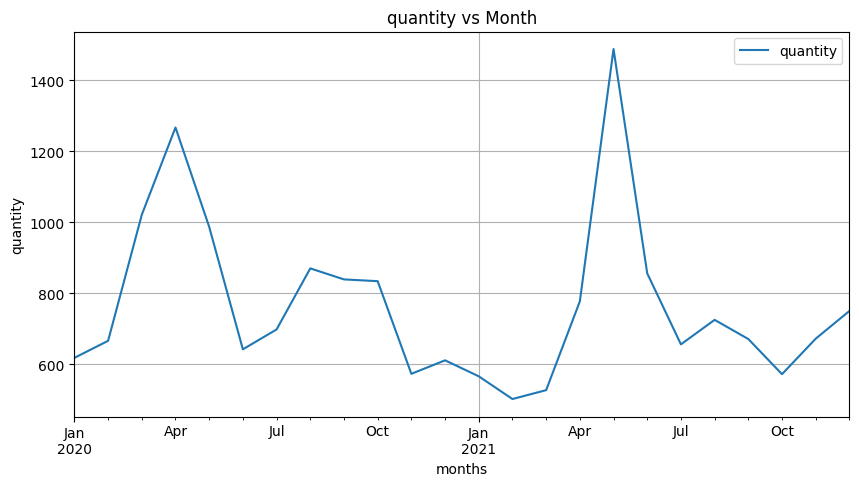

In [11]:
df.plot(figsize=(10,5))
plt.title("quantity vs Month")
plt.xlabel("months")
plt.ylabel("quantity")
plt.grid()

In [12]:
round(df.describe())

,quantity
count,24.0
mean,766.0
std,234.0
min,502.0
25%,616.0
50%,685.0
75%,843.0
max,1488.0


In [13]:
round(df.describe(),3)

,quantity
count,24.000
mean,766.167
std,234.490
min,502.000
25%,616.250
50%,685.000
75%,843.250
max,1488.000


In [14]:
from statsmodels.graphics.tsaplots import month_plot

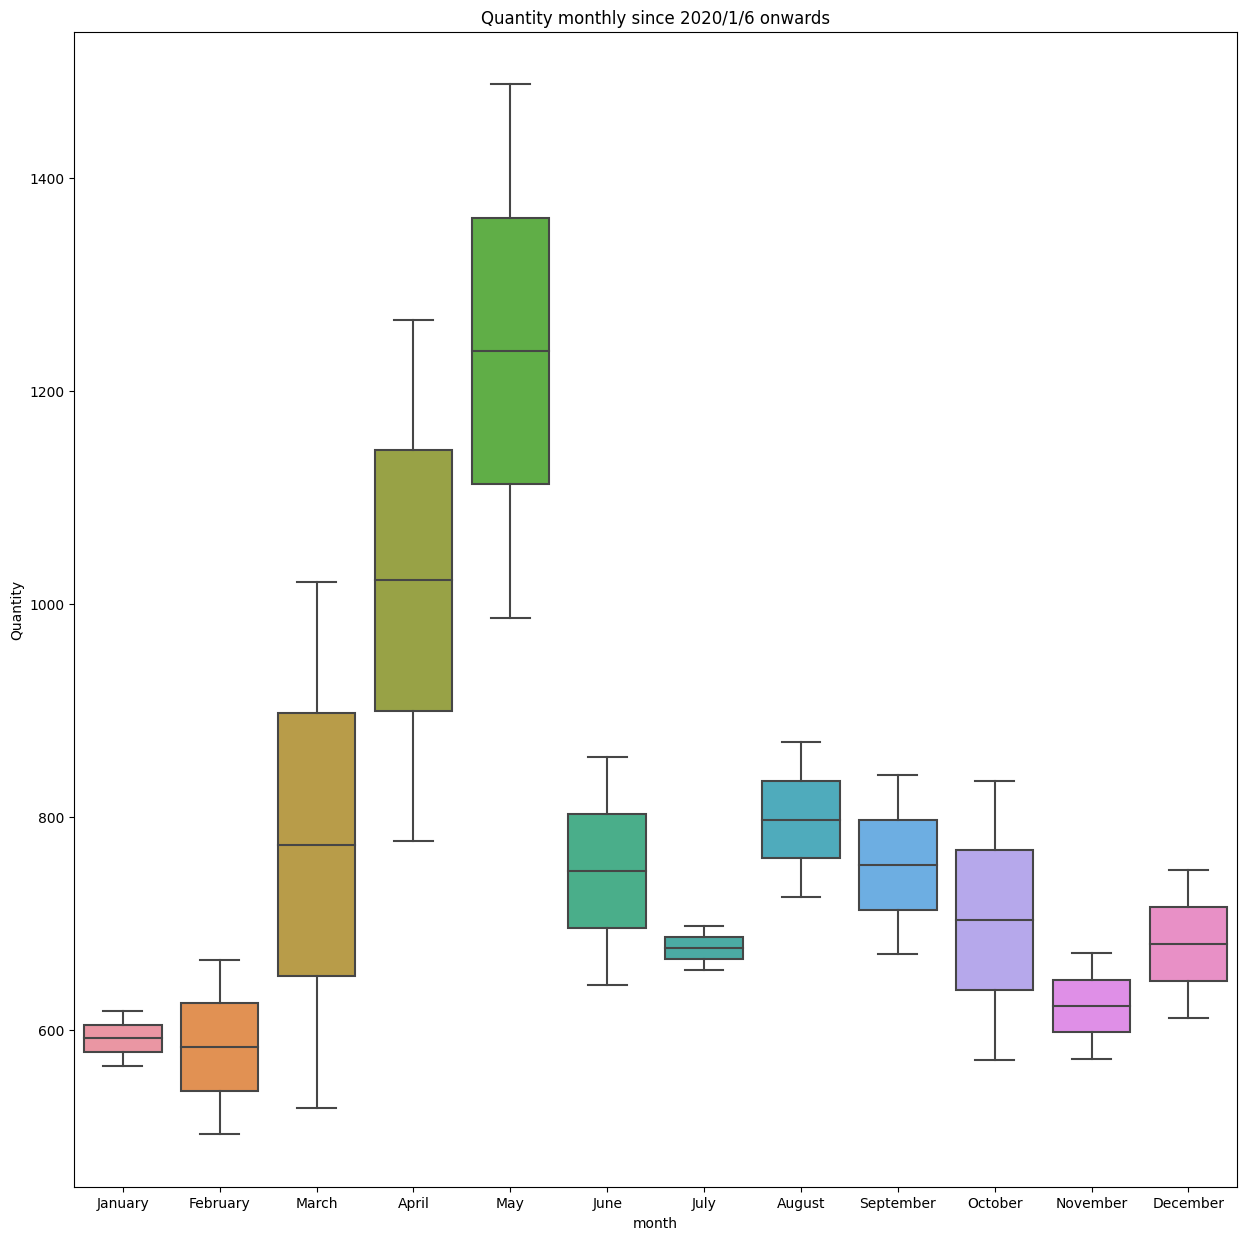

In [15]:
_, ax = plt.subplots(figsize=(15,15))
sns.boxplot(x = df.index.month_name(), y = df.values[:, 0], ax=ax)
plt.title("Quantity monthly since 2020/1/6 onwards")
plt.xlabel("month")
plt.ylabel("Quantity")
plt.show();

              quantity
month                 
2020-12-31  802.166667
2021-12-31  730.166667


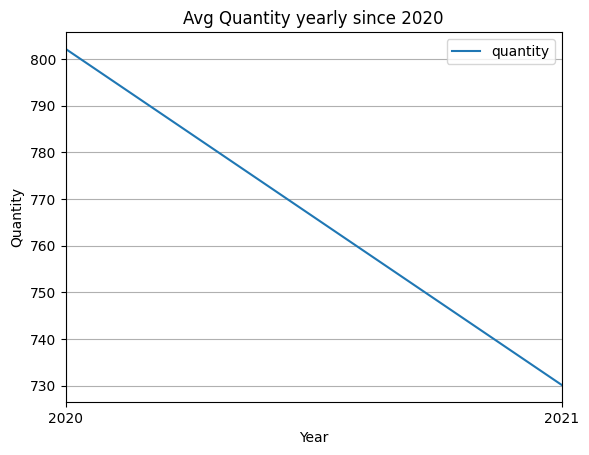

In [16]:
df_yearly_sum = df.resample('A').mean()
print(df_yearly_sum)
df_yearly_sum.plot();
plt.title("Avg Quantity yearly since 2020")
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.grid();

               quantity
month                  
2020-03-31   768.333333
2020-06-30   965.333333
2020-09-30   802.333333
2020-12-31   672.666667
2021-03-31   531.666667
2021-06-30  1040.333333
2021-09-30   684.000000
2021-12-31   664.666667


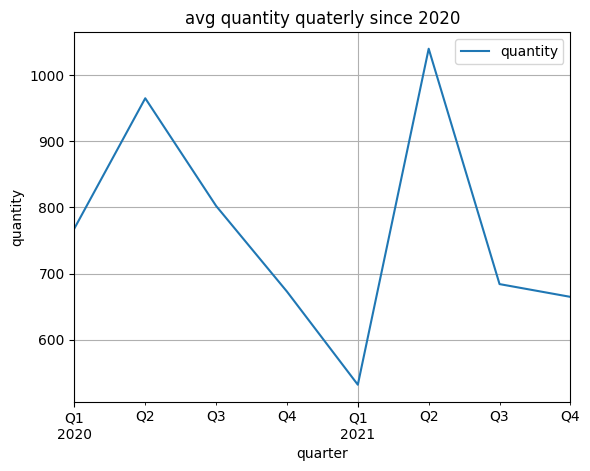

In [17]:
df_quarterly_sum = df.resample('Q').mean()
print(df_quarterly_sum)
df_quarterly_sum.plot();
plt.title("avg quantity quaterly since 2020")
plt.xlabel('quarter')
plt.ylabel('quantity')
plt.grid();

# Step 2. Analysis in coeffient of variation. CV means coeffient of variation in prices.

In [18]:
df_1 = df.groupby(df.index.month).mean().rename(columns= {'quantity':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.month).std().rename(columns={'quantity':'Std'}),left_index= True, right_index= True)
df_1['Cov_pct']=((df_1['Std']/df_1["Mean"])*100).round(2) #coefficient of variation (CV) expressed as a percentage
df_1.head()

,Mean,Std,Cov_pct
month,,,
1,592.0,36.769553,6.21
2,584.0,115.965512,19.86
3,774.0,349.310750,45.13
4,1022.0,346.482323,33.90
5,1237.5,354.260497,28.63


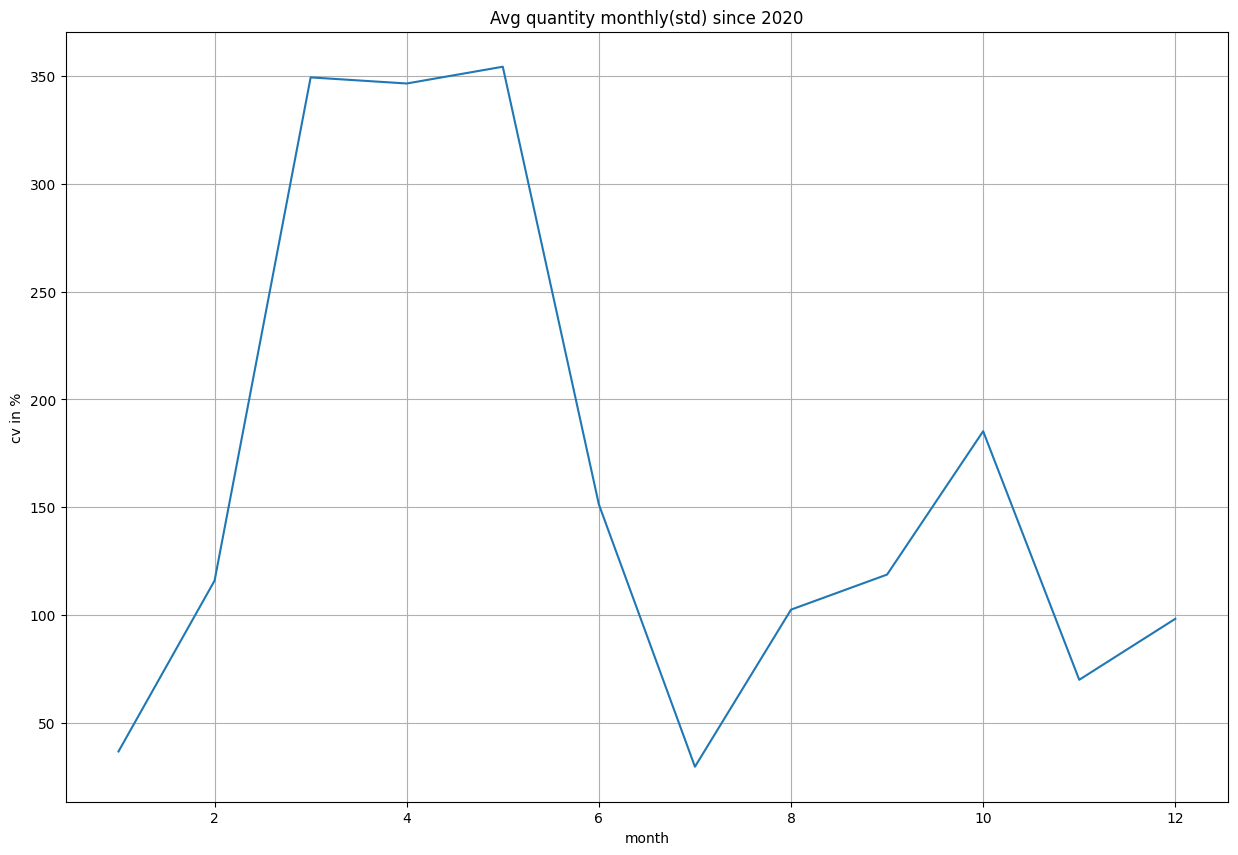

In [19]:
fig, ax = plt.subplots(figsize= (15,10))
df_1['Std'].plot();
plt.title("Avg quantity monthly(std) since 2020")
plt.xlabel('month')
plt.ylabel('cv in %') #coefficient of variation (CV) expressed as a percentage
plt.grid()

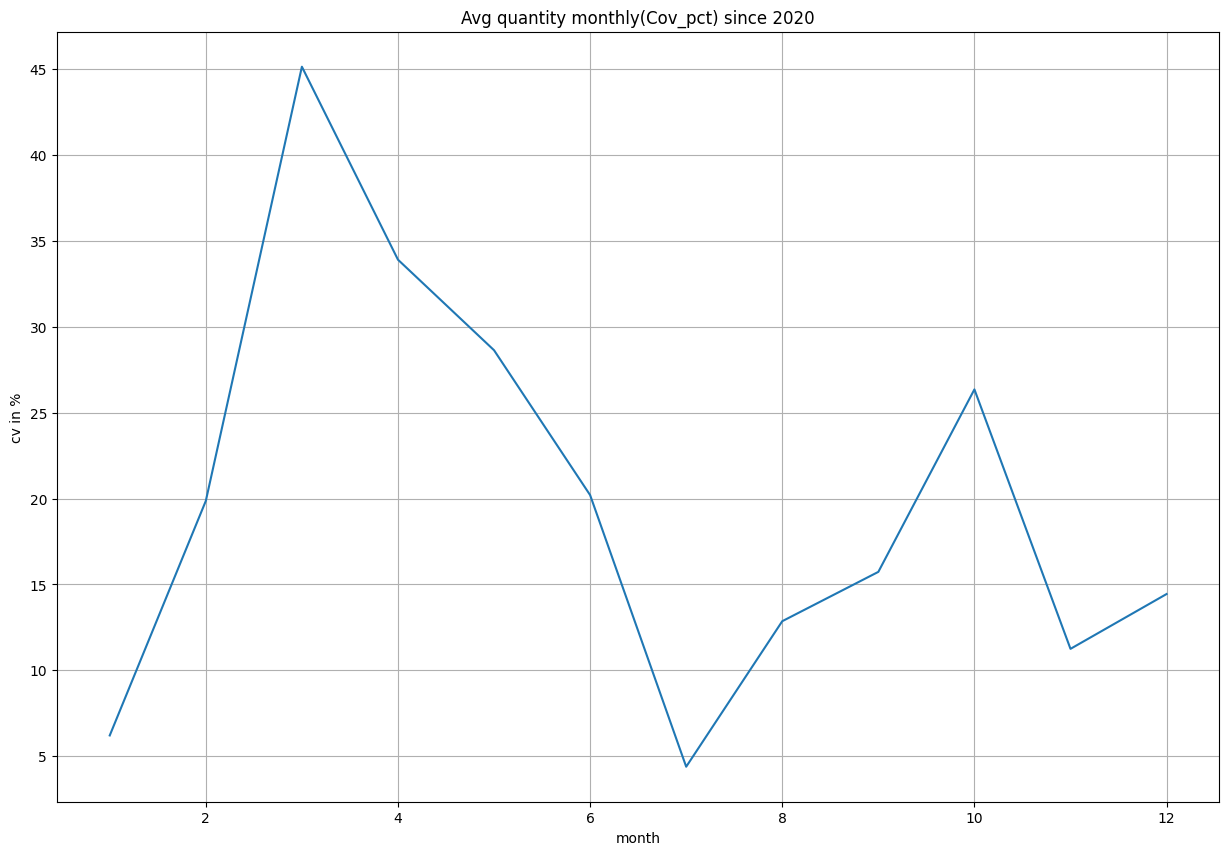

In [20]:
fig, ax = plt.subplots(figsize= (15,10))
df_1['Cov_pct'].plot();
plt.title("Avg quantity monthly(Cov_pct) since 2020")
plt.xlabel('month') #coefficient of variation (CV) expressed as a percentage
plt.ylabel('cv in %')
plt.grid()

# Step3.1: Time Series Forecasting

In [21]:
train = df[df.index <= "6/30/2021"]
test = df[df.index >= "6/30/2021"]

In [22]:
print(train)
print(test)

            quantity
month               
2020-01-31       618
2020-02-29       666
2020-03-31      1021
2020-04-30      1267
2020-05-31       987
2020-06-30       642
2020-07-31       698
2020-08-31       870
2020-09-30       839
2020-10-31       834
2020-11-30       573
2020-12-31       611
2021-01-31       566
2021-02-28       502
2021-03-31       527
2021-04-30       777
2021-05-31      1488
2021-06-30       856
            quantity
month               
2021-06-30       856
2021-07-31       656
2021-08-31       725
2021-09-30       671
2021-10-31       572
2021-11-30       672
2021-12-31       750


In [23]:
print(train.shape)
print(test.shape)

(18, 1)
(7, 1)


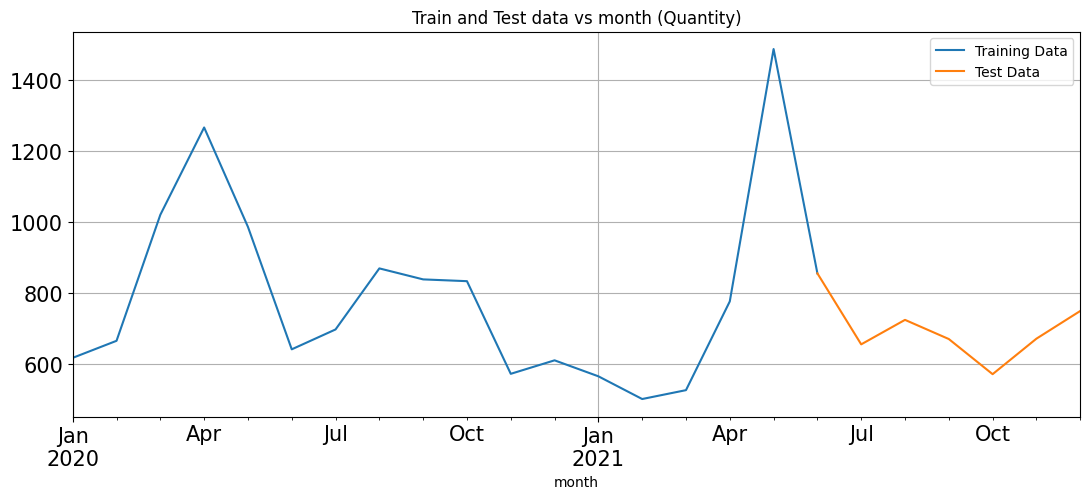

In [24]:
train["quantity"].plot(figsize=(13,5), fontsize =15)
test["quantity"].plot(figsize=(13,5), fontsize = 15)
plt.title("Train and Test data vs month (Quantity)")
plt.grid()
plt.legend(['Training Data', 'Test Data'])
plt.show()

# Step 3.2: Moving forward let's do model formation now.

# A. First we will go from Linear Regression

In [25]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time),len(test_time)

(18, 7)

In [26]:
LR_train = train.copy()
LR_test = test.copy()

In [27]:
LR_train['time']= train_time
LR_test['time']= test_time

In [36]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train["quantity"].values)


LinearRegression()

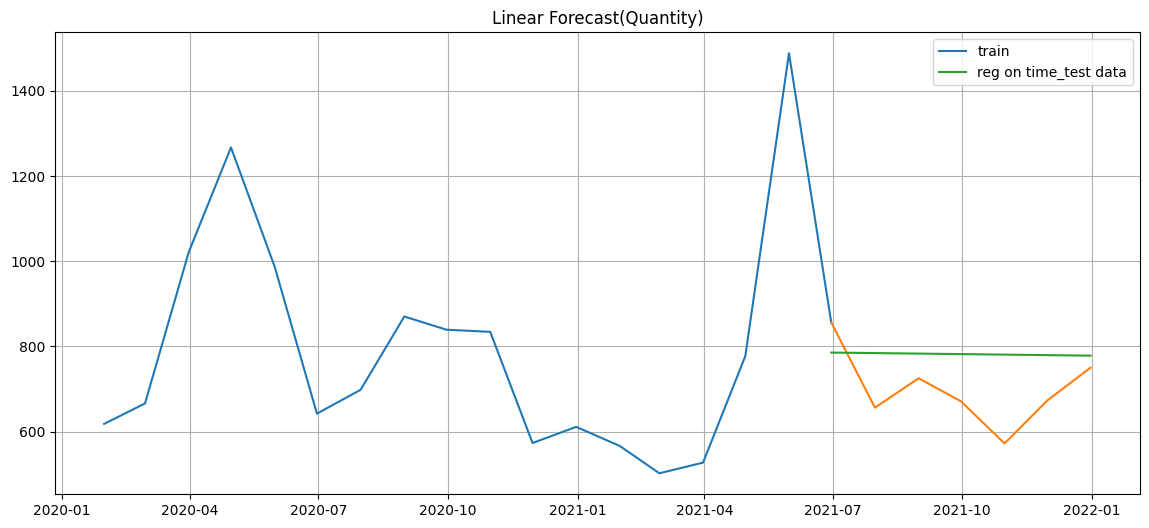

In [37]:
test_predictions_model1 = lr.predict(LR_test[["time"]])
LR_test['forecast'] = test_predictions_model1

plt.figure(figsize = (14,6))
plt.plot(train["quantity"], label = 'train')
plt.plot(test["quantity"])
plt.plot(LR_test['forecast'], label = 'reg on time_test data')
plt.title("Linear Forecast(Quantity)")
plt.legend(loc = 'best')
plt.grid();

In [38]:
def mape(actual, pred): 
    return round((np.mean(abs(actual - pred)/actual))*100,2)

In [39]:
mape_model1_test = mape(test['quantity'].values,test_predictions_model1)
print("MAPE is %3.3f"%(mape_model1_test),"%")

MAPE is 15.500 %


In [40]:
results = pd.DataFrame({'Test Mape (%)': [mape_model1_test]}, index=["RegressionOnTime"])
results

,Test Mape (%)
RegressionOnTime,15.5


# B. Second we will go from Naive Regression

In [41]:
Naive_train = train.copy()
Naive_test = test.copy()

In [42]:
Naive_test['naive']= np.asarray(train['quantity'])[len(np.asarray(train['quantity']))-1]
Naive_test['naive'].head()

month
2021-06-30    856
2021-07-31    856
2021-08-31    856
2021-09-30    856
2021-10-31    856
Name: naive, dtype: int64

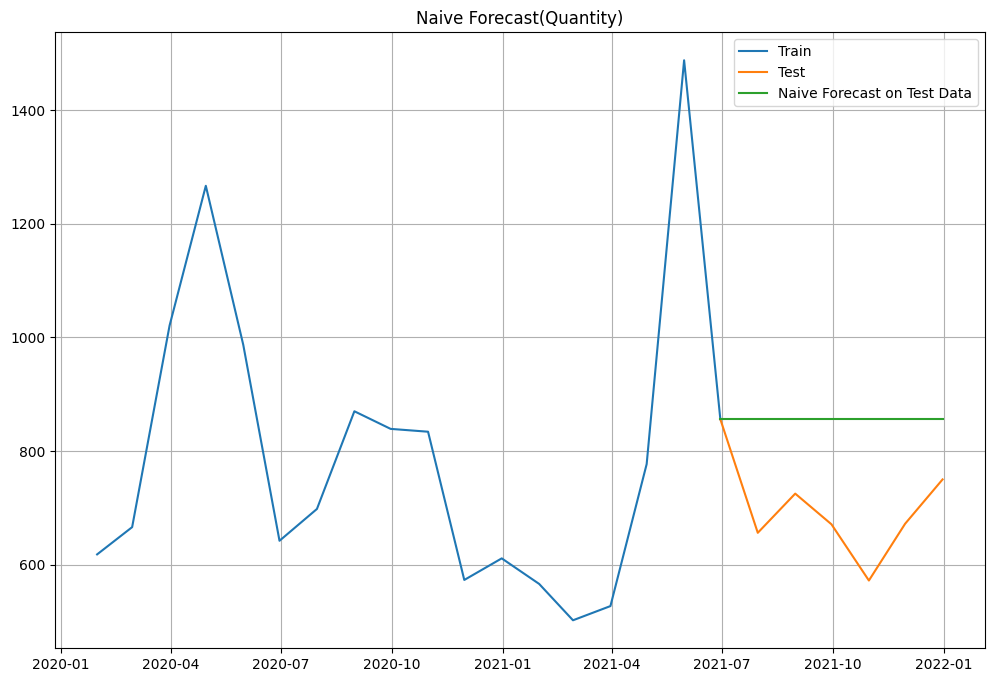

In [43]:
plt.figure(figsize = (12,8))
plt.plot(Naive_train["quantity"], label = 'Train')
plt.plot(test["quantity"], label = 'Test')
plt.plot(Naive_test['naive'], label = 'Naive Forecast on Test Data')
plt.legend(loc = 'best')
plt.title("Naive Forecast(Quantity)")
plt.grid();

In [44]:
mape_model2_test = mape(test['quantity'].values,Naive_test['naive'].values)
print("For Naive forecast on the Test Data ,MAPE is %3.3f" %(mape_model2_test),"%")

For Naive forecast on the Test Data ,MAPE is 23.900 %


In [45]:
resultsDf_2 = pd.DataFrame({'Test Mape (%)': [mape_model2_test]}, index=['NaiveModel'])
results = pd.concat([results,resultsDf_2])
results

,Test Mape (%)
RegressionOnTime,15.5
NaiveModel,23.9


# C. ExpnentialSmoothing

In [46]:
exponentialSmoothing = ExponentialSmoothing(df,
                                trend = 'additive',
                                seasonal = 'additive').fit(smoothing_level = 0.9,
                                                          smoothing_trend= 0.4,
                                                          smoothing_seasonal = 0.8)



In [47]:
Mape_expexponentialSmoothing = mape(df['quantity'].values, exponentialSmoothing.fittedvalues)

In [48]:
print("MAPE:", Mape_expexponentialSmoothing) # Mean absolute percentage error (MAPE)

MAPE: 14.02


In [49]:
resultsDf_2 = pd.DataFrame({'Test Mape (%)': [Mape_expexponentialSmoothing]}, index=['exponentialSmoothing'])
results = pd.concat([results,resultsDf_2])
results

,Test Mape (%)
RegressionOnTime,15.50
NaiveModel,23.90
exponentialSmoothing,14.02


# Step 4: Final Forecasting

In [50]:
prediction = exponentialSmoothing.forecast(steps=len(test))

In [51]:
pred_df = pd.DataFrame({'lower_CI': prediction - 1.96*np.std(exponentialSmoothing.resid,ddof=1),
                       'prediction': prediction,
                       'upper_CI': prediction+ 1.96*np.std(exponentialSmoothing.resid,ddof =1)})
pred_df.head() # Confidence Interval(CI) 

,lower_CI,prediction,upper_CI
2022-01-31,369.444534,767.858312,1166.272090
2022-02-28,365.520844,763.934622,1162.348400
2022-03-31,480.146079,878.559857,1276.973635
2022-04-30,919.660663,1318.074441,1716.488218
2022-05-31,1617.944277,2016.358055,2414.771832


In [52]:
pred_df.tail() # Confidence Interval(CI) 

,lower_CI,prediction,upper_CI
2022-03-31,480.146079,878.559857,1276.973635
2022-04-30,919.660663,1318.074441,1716.488218
2022-05-31,1617.944277,2016.358055,2414.771832
2022-06-30,546.789574,945.203352,1343.617130
2022-07-31,566.013495,964.427273,1362.841051


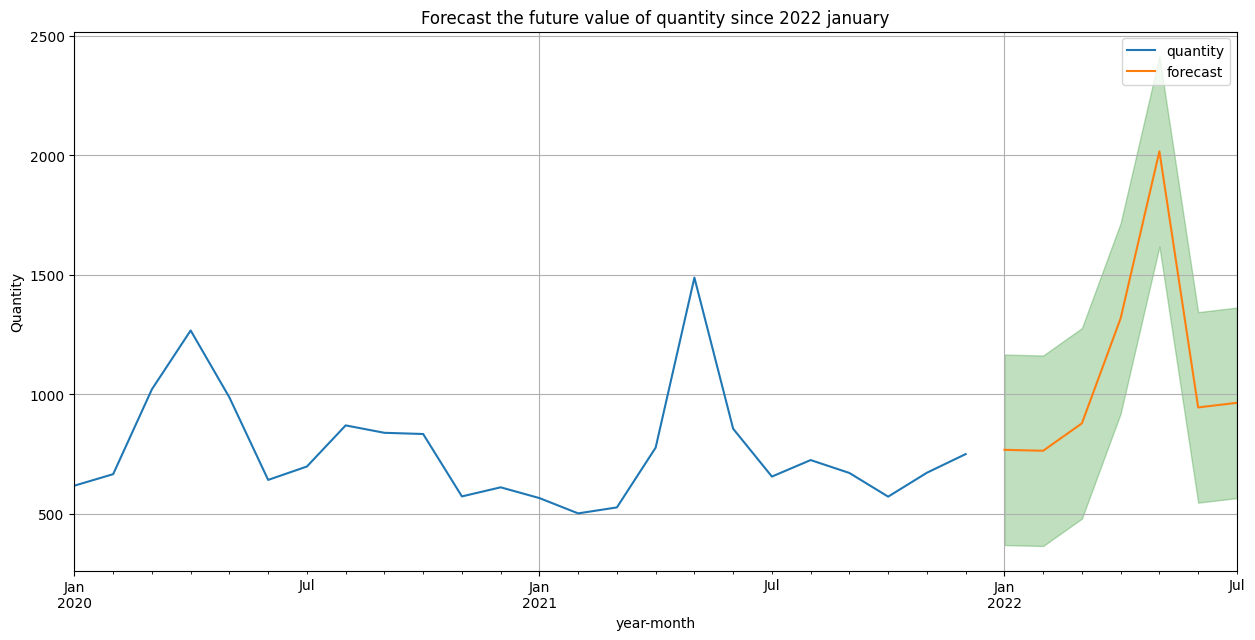

In [53]:
axis = df.plot(label = 'Actual', figsize=(15,7))
pred_df['prediction'].plot(ax= axis, label = 'forecast', alpha =1)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color ='g', alpha = .25)
plt.title("Forecast the future value of quantity since 2022 january")
axis.set_xlabel('year-month')
axis.set_ylabel('Quantity')
plt.legend(loc = 'best')  # Confidence Interval(CI) 
plt.grid()
plt.show()